## Simulador de la Cuenca de Salgar

El siguiente codigo se encarga de simular la cuenca de salgar a partir de la informacion de radar obtenida por Julian, para el evento de Mayo 18, 
se realiza la simulación con el DEM de 12.7 metros.

In [1]:
%matplotlib inline
from wmf import wmf 
import numpy as np
import pylab as pl
import datetime as dt
import pandas as pd 

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [ ]:
def plot_sim_single(Qs,Qo=None,mrain=None,Dates=None,ruta=None,
	figsize=(8,4.5),ids=None,legend=True,ax1 = None,**kwargs):
	'''ENTRADAS:
	Qs = Caudal simulado, variable tipo lista
	Qo = Caudal observado, variable tipo lista
	mrain = Lluvia media observada,variable tipo lista
	Dates = Indice de tiempo (Datetime), variable tipo lista
	ids = Identificador de puntos de control
	ax1 = axis o entorno para graficar
	**kwargs = Argumentos por defecto, se pueden cambiar.
	Estos argumentos son:

	ARGUMENTOS POR DEFECTO
	rain_alpha': 0.4, Transparencia de la lluvia
	rain_color': blue, Color de la lluvia
	rain_lw : 0, Ancho de linea de lluvia
	rain_ylabel: Precipitation [$mm$], Etiqueta del eje y de la lluvia
	label_size: 14, Tamano de fuente 
	rain_ylim : Se ajusta, Limite del eje y
	ColorSim : ['r','g','k','c','y'], Colores para simulacion de caudal
	Qs_lw : 1.5, Ancho de linea de caudal simulado
	Qo_lw : 2.0, Ancho de linea de caudal observado
	Qs_color : red, Color de linea de caudal simulado
	Qo_color : blue, Color de linea de caudal observado
	Qo_label : Observed, Leyenda de caudal observado
	Qs_label : Simulated, Leyenda de caudal simulado
	xlabel : Time [$min$], Etiqueta del eje x
	ylabel : Streamflow $[m^3/seg], Etiqueta del eje y
	legend_loc : upper center, Ubicacion de la leyenda
	bbox_to_anchor : (0.5,-0.12), Ajuste de la caja de la leyenda
	legend_ncol : 4, Numero de columnas para la leyenda
	'''
        show = kwargs.get('show',True)
	if ax1 == None:
		fig=pl.figure(facecolor='w',edgecolor='w',figsize=figsize)
		ax1=fig.add_subplot(111)
	else:
		show = False
	#Fechas
	if Dates==None:
		if len(Qs.shape)>1:
			ejeX=range(len(Qs[0]))
		else:
			ejeX = range(len(Qs))
	else:
		ejeX=Dates
	#Grafica la lluvia
	if mrain<>None:
		ax1AX=pl.gca()
		ax2=ax1.twinx()
		ax2AX=pl.gca()
		alpha = kwargs.get('rain_alpha',0.4)
		color = kwargs.get('rain_color','blue')
		lw = kwargs.get('rain_lw',0)
		ax2.fill_between(ejeX,0,mrain,alpha=alpha,color=color,lw=lw)
		ylabel = kwargs.get('rain_ylabel','Precipitation [$mm$]')
		label_size = kwargs.get('label_size',14)
		ax2.set_ylabel(ylabel,size=label_size)
		ylim = kwargs.get('rain_ylim',ax2AX.get_ylim() [::-1])
		ax2AX.set_ylim(ylim)
	else:
		ax2 = None    
	#grafica las hidrografas
	ColorSim=kwargs.get('ColorSim',['r','g','k','c','y'])
	Qs_lw = kwargs.get('Qs_lw',1.5)
	Qo_lw = kwargs.get('Qo_lw',2.0)
	Qs_color = kwargs.get('Qs_color','r')
	Qo_color = kwargs.get('Qo_color','b')
	Qo_label = kwargs.get('Qo_label','Observed')
	Qs_label = kwargs.get('Qs_label','Simulated')
	if len(Qs.shape)>1:
		if ids is None:
			ids = np.arange(1,Qs.shape[0]+1)
		for i,c,d in zip(Qs,ColorSim,ids):
			ax1.plot(ejeX,i,c,lw=Qs_lw,label=str(d))    
	else:
		ax1.plot(ejeX,Qs,Qs_color,lw=Qs_lw,label=Qs_label)    
	if Qo<>None: ax1.plot(ejeX,Qo,Qo_color,lw=Qo_lw,label=Qo_label)
	#Pone elementos en la figura
	xlabel = kwargs.get('xlabel','Time [$min$]')
	ylabel = kwargs.get('ylabel','Streamflow $[m^3/seg]$')
	label_size = kwargs.get('label_size', 16)
	ax1.set_xlabel(xlabel,size=label_size)
	ax1.set_ylabel(ylabel,size=label_size)
	ax1.grid(True)
	loc = kwargs.get('legend_loc','upper center')
	bbox_to_anchor = kwargs.get('bbox_to_anchor',(0.5,-0.12))
	ncol = kwargs.get('legend_ncol',4)
	if legend == True:
		lgn1=ax1.legend(loc=loc,) #bbox_to_anchor=bbox_to_anchor,
			#fancybox=True, shadow=True, ncol=ncol)
	if ruta<>None:
		pl.savefig(ruta, bbox_inches='tight')
	if show == True:
		pl.show()
	return ax1, ax2

Lectura de mapas de direcciones y de elevación:

In [2]:
DEM=wmf.read_map_raster('/media/nicolas/Home/nicolas/03_SALGAR/raster/dem_salgar.tif',True)
DIR=wmf.read_map_raster('/media/nicolas/Home/nicolas/03_SALGAR/raster/dir_salgar.tif',True)
wmf.cu.nodata=-9999.0; wmf.cu.dxp=12.7
DIR[DIR<=0]=wmf.cu.nodata.astype(int)
DIR=wmf.cu.dir_reclass(DIR,wmf.cu.ncols,wmf.cu.nrows)

## Trazado de la cuenca y preparación de la misma 

A continuación se traza la cuenca de salgar y se preparan los parametros geomorfológicos y físicos, posteriormente se establecen las
condiciones para la simulación

In [3]:
s = wmf.Stream(-76.05,5.99,DEM,DIR)

In [4]:
# Trazado de la cuenca 
cuSalgar = wmf.SimuBasin(-75.9808, 5.9647, DEM, DIR, name='Liboriana',
    dt = 300, stream = s )
cuSalgar.Save_Basin2Map('/media/nicolas/Home/nicolas/03_SALGAR/vector/cuenca12m.shp')
cuSalgar.Save_Net2Map('/media/nicolas/Home/nicolas/03_SALGAR/vector/red12m.shp',umbral=2000)

In [5]:
cuSalgar.GetGeo_Cell_Basics()

In [6]:
cuSalgar.set_Geomorphology()

In [7]:
# Establecer Parametros Geomorfo
cuSalgar.GetGeo_Cell_Basics()
cuSalgar.set_Geomorphology(stream_width=cuSalgar.CellLong,umbrales=[200,2000])

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:3150: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if stream_width==None:


## Ejemplo EVP

In [8]:
cuSalgar.GetQ_Balance(2300)
print cuSalgar.CellQmed[-1]

2.60499


http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-76.0948989531,5.92463182009,-75.9796567775,6.01716450808&bboxSR=4326&imageSR=4326&size=1500,1204&dpi=96&format=png32&f=image


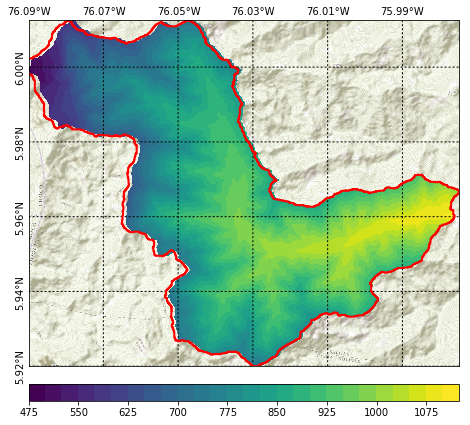

855.236


In [17]:
#Ejemplo turc
cuSalgar.GetQ_Balance(2300, Tipo_ETR=1)
cuSalgar.Plot_basin(cuSalgar.CellETR, backMap=True)
print cuSalgar.CellETR.mean()

In [15]:
cuSalgar.GetQ_Balance(2300, Tipo_ETR=3)
#cuSalgar.Plot_basin(cuSalgar.CellETR)
print cuSalgar.CellETR.mean()

1335.47


### Parámetros físicos.

Los parámetros físicos del modelo se dividen en velocidades verticales y vel horizontales,  las cuales a su ves se dividen en versiones lineales y no lineales de las mismas, en el caso de las velocidades verticales todas las relaciones son lineales, a continuación se describen las variables relacionadas con los flujos que se encuentran en el modelo:

- Velocidades Verticales:
    - Tanque 1 a exterior (evaporacion): controlado por $EVP$, en el modelo se representa como **vspeed(1,:) = v_coef(1,:)R[1]dt**
    - Tanque 1 a Tanque 2 (Sat del capilar): controlado por $H_u$ y por la precipitación $P_{t}$.
    - Tanque 2 a Tanque 3 (infiltracion): controlado por $k_s$, el cual en el modelo se representa mediante **vspeed(2,:) = v_coef(2,:)R[2]dt**
    - Tanque 3 a Tanque 4 (percolación): controlado por $k_p$ el cual en el modelo se representa mediante **vspeed(3,:) = v_coef(3,:)R[3]dt**
    - Tanque 4 a Perdidas (perdidas); controlado por $k_{pp}$ en el modelo se presenta como **vspeed(4,:) = v_coef(4,:)R[4]dt**
    
    
- Velocidades Horizontales:
    - Salida Tanque 2: Se representa como $v_2$ y en el modelo esta atada a: **hspeed(1,:) = h_coef(1,:)R[5]** en el caso lineal, y en el no lineal se involucra el termino **h_exp(1,:)**
    - Salida Tanque 3: Se representa como $k_{sh}$ o $v_{3}$ en el modelo se muestra commo: **hspeed(2,:) = h_coef(2,:)R[6]**, enn el caso no lineal el termino **h_exp(2,:)** entra.
    - Salida Tanque 4: Se representa como $k_{ph}$ o $v_{4}$ en el modelo se muestra commo: **hspeed(3,:) = h_coef(3,:)R[7]**, en el caso no lineal el término **h_exp(3,:)** se tiene en cuenta.
    - Salida Tanque 5: Se representa como $v_{5}$, el modelo esta atado a **h_coef(4,:)** y a **h_exp(4,:)**, siempre es no lineal, en calibración el parámetro **R[8]** es el responsable.

- Almacenamientos:
    - Almacenamiento capilar: **H(1,:) = Max_capilar(1,:) R[9]**
    - Almacenamiento gravitacional: **H(2,:) = Max_gravita(1,:) R[10]**

La calibración se compone de 10 parámetros escalares, los cuales son:
- R[1] : Evaporación.
- R[2] : Infiltración.
- R[3] : Percolación.
- R[4] : Pérdidas.
- R[5] : Vel Superficial.
- R[6] : Vel Sub-superficial.
- R[7] : Vel Subterranea.
- R[8] : Vel Cauces.
- R[9] : Alm capilar maximo.
- R[10] : Alm gravitacional maximo.

### Preparación parámetros verticales 

- **EVP**: se asume según la ecuación de Turc y se divide por el tamano de $\delta t$.
- **ks**: se asume contante para toda la cuenca e igual a $1mm/h$.
- **kp**: se va a asumir como dos ordenes de magnitud por debajo de **ks**.

In [9]:
# Evaporación en la cuenca estimada por Turc.
Evp=4.658*np.exp(-0.0002*cuSalgar.CellHeight)/288.0
# Infiltración Ks [mm/s]
Ks = 0.00126
# Percolación 
Kp = Ks/10.0
# Perdidas se asumen iguales a cero 
Kpp = 0.0
# Inclusión de los parámetros en el modelo 
Lista=[Evp,Ks,Kp,Kpp]
for pos,var in enumerate(Lista):
    cuSalgar.set_PhysicVariables('v_coef',var,pos)


### Preparación parámetros horizontales

- **v2**: velocidad superficial se asume igual a 0.1 m/seg.
- **v3**: velocidad sub-superficial se asume igual a $k_s$.
- **v4**: velocidad subterranea asumida igual a $k_p$.

In [10]:
# Velocidades superficial, sub-super, y subte.
v2 = 1.4 * cuSalgar.CellSlope**0.5
v3 = Ks * cuSalgar.CellSlope**0.5
v4 = Kp * cuSalgar.CellSlope**0.5
Lista=[v2,v3,v4]
for pos,var in enumerate(Lista):
    cuSalgar.set_PhysicVariables('h_coef',var,pos)

### Preparación parámetros en el cauce 

para preparar los parámetros del cauce se deben calcular el coeficiente y el exponente que tienen que ser resueltos para obtener el flujo.



In [11]:
#Calcula variable para el coeficiente horizontal 
area = cuSalgar.CellAcum * (12.7**2) #Tamaño de celda al cuadrado
var,w1 = wmf.OCG_param(pend = cuSalgar.CellSlope, area = area)
cuSalgar.set_PhysicVariables('h_coef',var,3)
#Variable del exponente horizontal 
cuSalgar.set_PhysicVariables('h_exp',w1,3)

/usr/local/lib/python2.7/dist-packages/wmf/wmf.py:611: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pend<>None and area<>None:


### Prepara puntos de control y tipo de velocidad a usar 

>En este caso solo se registran caudales a la salida de la cuenca.
y el tipo de velocidad es lineal para todos los tanques excepto para el 5to, en donde la velocidad siempre es cinematica.

In [14]:
#Genera puntos de control y los transporta al cauce
coordXY = np.array([[-76.0426,5.9858],
    [-76.02944,5.9548],
    [-76.0159,5.95572]]).T
ids = np.array([200, 201, 202])
cuSalgar.set_Speed_type()

Ids = cuSalgar.set_Control(coordXY,ids,tipo='Q')
order = wmf.models.control[wmf.models.control<>0]

#Puntos de control de humedad 
coordHumedad = np.array([[-76.08, 6.00],
    [-76.055,5.98],
    [-76.03,5.95],
    [-76.0014,5.9619]]).T
idsHumedad = np.array([300,301,302,303])
IdsHumedad = cuSalgar.set_Control(coordHumedad,idsHumedad,tipo='H')
wmf.Save_Points2Map(coordXY,ids,'/media/nicolas/Home/nicolas/03_SALGAR/vector/ptos_controlQ.shp')
wmf.Save_Points2Map(coordHumedad,idsHumedad,'/media/nicolas/Home/nicolas/03_SALGAR/vector/ptos_controlH.shp')

## Descipción suelos de Salgar 

A continuación se dan algunas descripciones d elos suelos de salgar, que pueden ser de utilidad para la simulación.
También se presentan las ecuaciones usadas para determinar capacidades de almacenamiento, y velocidades de drenaje de acuerdo a la descripción del suelo.

### Descripción de acuerdo al IGAC:
| **Tipo** | **Pendiente**| **Profundidad** | **Retención** | **Permeabilidad** |
|----------|-------------|-------------|-------------|-------------|
|**Clase III**| 12-25 | Media : $0.6m$ | Media | Media |
|**Clase IV**| < 12 | Media : $0.6m$ | Baja | Baja |
|**Clase VI**| 25-30 | Profundo $1.0mts$ | Media | Media |
|**Clase VII**| 30-50 | Superficial $0.3m$| Muy baja | Lenta |
|**Clase VIII**| > 50 | Superficial $0.2m$| Muy baja | Lenta |

Estos suelos se describen como suelos de color pardo amarillento a rojizo de textura franco-arcilloza, y cascajos.
en general bien drenados y con poca capacidad de retención (poca memoria?). En general también son descritos como suelos profundos (Osorio, 2008) (**Unidades de suelo representativas de la Zona Cafetera Colombiana**), según la literatura un suelo profundo es más de un metro.

___
### Descripción de las características de este suelo de acuerdo a SPAW 

>- Capacidad almacenamiento: $0.14 cm/cm$
>- $\theta_{cc}$: Humedad a capacidad de campo, se asume igual a: $35\%$
>- $\theta_{pmp}$: Humedad en el punto de marchitez, se asume igual a: $21.3\%$
>- $\theta_{s}$: Humedad en el punto de saturación, se asume igual a: $47.2\%$
>- $K_s$ : Conductividad hidraulica saturada: $4.56 mm/hr$ o $0.00126 mm/seg$

___

De acuerdo a Saxton, 2006, la conductividad hidraulica del suelo puede variar de acuerdo a las siguientes ecuaciones:

>- $K = K_s (\theta / \theta_{s})^{\left[3+(2/\lambda)\right]}$
>- $\lambda = 1/B$
>- $B = [ln(1500) - ln(33)]/[ln(\theta_{33})-ln(\theta_{1500})]$
>- $\theta_{33}$ es la humedad a $33Kpa$, en este caso igual a $37\%$.
>- $\theta_{1500}$ es la humedad a $1500Kpa$, en este caso igual a $21.3\%$

**Almacenamiento máximo**:
Se tienen dos almacenamientos máximos, el capilar y el gravitacional, las ecuaciones que los rigen son:

>- Capilar: $H_u = Z (\theta_{cc} - \theta_{pmp})$
>- Gravitacional : $H_g = Z (\theta_{s} - \theta_{cc})$

### Ecuación no lineal de flujo lateral (kubota y Sivapalan)

La ecuación se describe de la siguiente manera:

$k_{h}=\frac{R*k_{s}S_{0} \Delta x^2}{3H_{g}^2} A ^2$

En este caso $A$ es el área de la sección equivalente en una celda, esta se puede asumir como un porcentaje del área total del flujo que sale por la sección transversal del tanque.

In [12]:
#Mapa de profundidades:
Z = np.zeros(cuSalgar.ncells)
Z[cuSalgar.CellSlope<0.25]=0.6
Z[(cuSalgar.CellSlope>=0.25)&(cuSalgar.CellSlope<0.30)]=1.0
Z[(cuSalgar.CellSlope>=0.30)&(cuSalgar.CellSlope<0.50)]=0.3
Z[cuSalgar.CellSlope>=0.5] = 0.2
#Mapas de almacenamiento maximo capilar y gravitacional
Hu = Z * (0.35 - 0.213) * 1000
Hg = Z * (0.47 - 0.35) * 1000
#cuSalgar.Plot_basin(vec=Z,ruta='imagenes12/ProfEfectivaSuelo.png')

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-76.0948989531,5.92463182009,-75.9796567775,6.01716450808&bboxSR=4326&imageSR=4326&size=1500,1204&dpi=96&format=png32&f=image


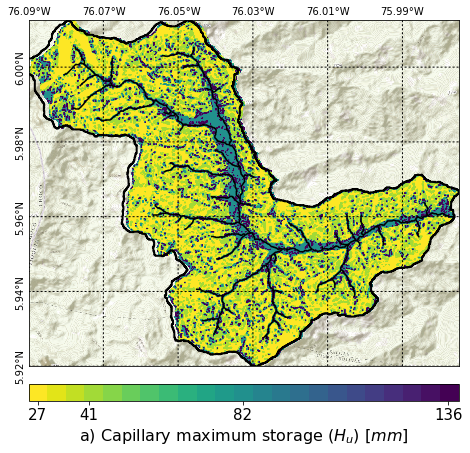

(<mpl_toolkits.basemap.Basemap at 0x7f43e7f18150>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43e7ee2810>)

In [60]:
Texto = ['%d' % i for i in np.unique(Hu)]
cuSalgar.Plot_basin(Hu,colorbarLabel='a) Capillary maximum storage ($H_u$) [$mm$]', 
    colorTable = pl.get_cmap('viridis_r'),per_color = 'k',
    ruta='/home/nicolas/Dropbox/Articulos_Prep/Salgar/Figura4_1_Hu.png', backMap = True,
    cbar_ticks = np.unique(Hu),
    cbar_ticklabels = Texto,
    cbar_ticksize = 15,
    rutaShp='/media/nicolas/Home/nicolas/03_SALGAR/vector/red12m',
    shpColor = 'k',shpWidth = 1.5)

In [13]:
cuSalgar.set_PhysicVariables('capilar',Hu,0)
cuSalgar.set_PhysicVariables('gravit',Hg,0)
wmf.models.retorno = 1.0

### Ecuación no lineal de flujo lateral (kubota y Sivapalan)

La ecuación se describe de la siguiente manera:

$k_{h}=\frac{R*k_{s}S_{0} \Delta x^2}{3H_{g}^2} A ^2$

En este caso $A$ es el área de la sección equivalente en una celda, esta se puede asumir como un porcentaje del área total del flujo que sale por la sección transversal del tanque.



In [14]:
# Ejemplo de solucionador de onda cinematica por multiples remplazos
def sol(sm,coef,expo,dx,dt):
    v = 0.00127
    for i in range(4):
        Area = sm*0.9 / (dx + v*dt)
        vn = coef * Area ** expo
        v = (2*vn + v)/3.0
    return Area,v
#Calculo de coeficiente por kubota y ensayo de como funciona
ksh=(Ks*cuSalgar.CellSlope*(12.7**2.0))/(3*(Hg*0.9/1000.0)**2)
speed = 1
area,v = sol(80,100,2.0,12.7,300.0)
print v
print area
print 1.0 - 30.0/(v*300.0+30.0)

74.8046557852
0.00106925153697
0.998664969501


In [52]:
kshClass = np.zeros(cuSalgar.ncells)
for c,i in enumerate([20,50,100,120,150]):
    kshClass[ksh>i] = c+1

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-76.0948989531,5.92463182009,-75.9796567775,6.01716450808&bboxSR=4326&imageSR=4326&size=1500,1204&dpi=96&format=png32&f=image


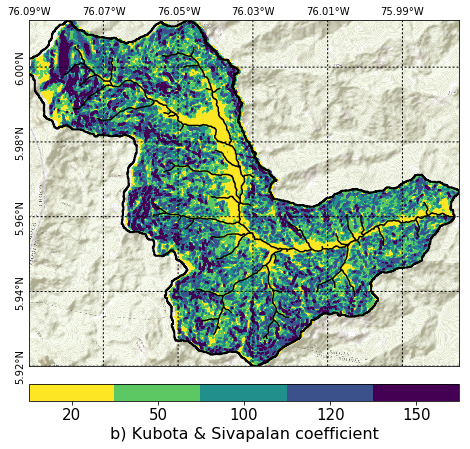

(<mpl_toolkits.basemap.Basemap at 0x7f43ebee4ad0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f43ec0dee50>)

In [58]:
Texto = ['%d' % i for i in [20,50,100,120,150]]
cuSalgar.Plot_basin(kshClass, colorTable=pl.get_cmap('viridis_r',5), colorbarLabel='b) Kubota & Sivapalan coefficient',
    ruta = '/home/nicolas/Dropbox/Articulos_Prep/Salgar/Figura4_2_ksh.png', per_color = 'k',
    backMap = True,
    cbar_ticks = np.unique(kshClass)+0.5,
    cbar_ticklabels = Texto,
    cbar_ticksize = 15,
    rutaShp='/media/nicolas/Home/nicolas/03_SALGAR/vector/red12m',
    shpColor = 'k',shpWidth = 1.5)

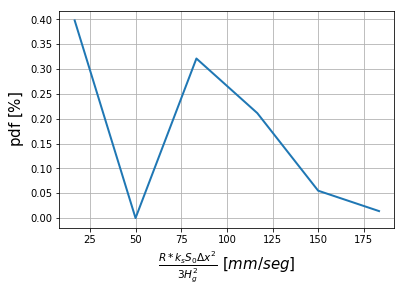

In [62]:
pos = np.random.choice(cuSalgar.ncells,10000)
h,b = np.histogram(ksh,bins=np.linspace(0,200,7))
h = h.astype(float); h = h/h.sum()
b = (b[:-1]+b[1:])/2.0
pl.plot(b,h,lw = 2)
pl.grid(True)
pl.xlabel('$\\frac{R*k_{s}S_{0} \\Delta x^2}{3H_{g}^2}$ $[mm/seg]$',size=15)
pl.ylabel('pdf $[\\%]$',size=15)
pl.savefig('/home/nicolas/Dropbox/Articulos_Prep/Salgar/PDF_Coef_khs_12m.png',bbox_inches='tight')

In [15]:
# Establece el coeficiente y el exponente para la version no lineal de sub-superficial 
cuSalgar.set_PhysicVariables('h_coef',ksh,1)
cuSalgar.set_PhysicVariables('h_exp',2.0,1)
wmf.models.speed_type[1] = 2

## Ejecución modelo
A continuación se realiza una ejecución ensayo del modelo, ojo esta es una prueba inicial puede fallar facilmente 
___

#### De nuevo calibración 

La calibración se compone de 10 parámetros escalares, los cuales son:
- R[1] : Evaporación.
- R[2] : Infiltración.
- R[3] : Percolación.
- R[4] : Pérdidas.
- R[5] : Vel Superficial.
- R[6] : Vel Sub-superficial.
- R[7] : Vel Subterranea.
- R[8] : Vel Cauces.
- R[9] : Alm capilar maximo.
- R[10] : Alm gravitacional maximo.

### Actualización estados y ejecución modelo 

In [61]:
cuSalgar.Save_SimuBasin('/media/nicolas/Home/nicolas/03_SALGAR/nc_cuencas/cuencaSalgar_3_12mts.nc',
    ruta_dem = '/media/nicolas/Home/nicolas/03_SALGAR/raster/dem_salgar.tif',
    ruta_dir = '/media/nicolas/Home/nicolas/03_SALGAR/raster/dir_salgar.tif')

In [622]:
cuSalgar = wmf.SimuBasin(rute='/media/nicolas/Home/nicolas/03_SALGAR/nc_cuencas/cuencaSalgar_3_12mts.nc')

In [206]:
#Actualizar estados
for pos,i in enumerate(Res['Storage']):
    cuSalgar.set_Storage(i+0.01,pos)

In [218]:
#Reiniciar estados
cuSalgar.set_Storage(Hu,0)
cuSalgar.set_Storage(2,0)

In [54]:
wmf.models.speed_type = np.array([1,2,1])

In [230]:
#wmf.models.storage = Res['Storage']
wmf.models.separate_fluxes = 1
wmf.models.show_storage = 1
wmf.models.separate_rain = 1
#cuSalgar.set_Storage(1500,3)
#cuSalgar.set_Storage(0.1,2)
#cuSalgar.set_Storage(0,0)
Npasos = 300
Inicio = 1
Calibracion = [0.1, 2.7, 0.8, 0.0, 1.0, 1.5, 0.01, 0.996, 1.0, 1.0]
Calibracion = [0.1, 2.7, 0.8, 0.0, 0.5, 1.0, 0.5, 0.996, 1.0, 1.0]
ruta_lluvia = '/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Mayo_18_19_12mts.bin'
ruta_store = '/media/nicolas/Juesnei/Nicolas/03_Salgar/bin_sto/Salgar_Mayo8-19.bin'
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio,ruta_storage=ruta_store)
S = wmf.read_mean_rain('/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Mayo_18_19_12mts.hdr',Npasos,Inicio)

In [579]:
Rain = wmf.read_mean_rain('/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Mayo_18_19_12mts.hdr',Npasos,Inicio)

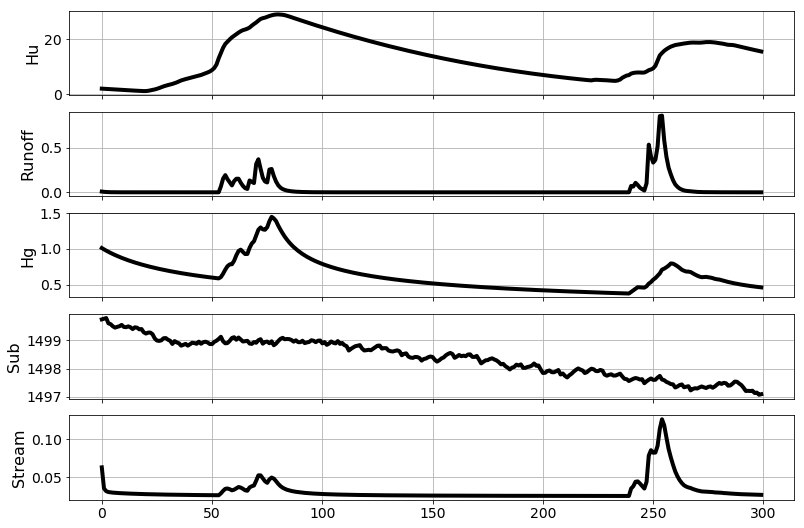

In [220]:
wmf.plot_mean_storage(Res['Mean_Storage'])

In [223]:
pos = np.where(wmf.models.control<>0)[1]
wmf.models.control[0][pos]
DictQsim = {}
for p,i in zip(wmf.models.control[0][pos], Res['Qsim'][1:]):
    DictQsim.update({str(p):i})
DictQsim = pd.DataFrame(DictQsim, index=S.index)

In [225]:
Texto = [i.strftime('%d/%H:%M') for i in S.index.to_pydatetime()]

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


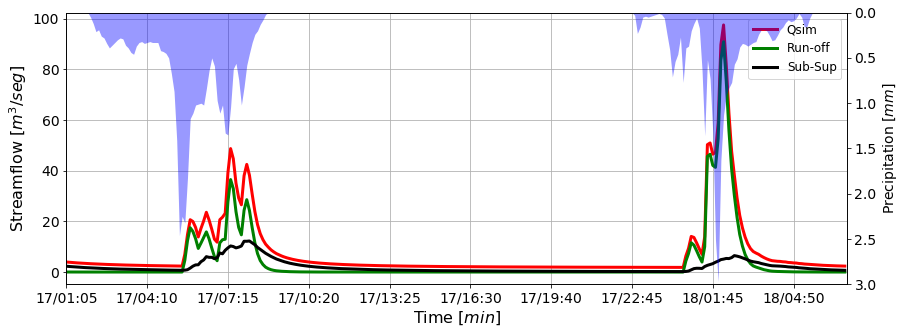

In [229]:
Qrun = Res['Fluxes'][-3][0]
Qsub = Res['Fluxes'][-3][1]
Qsim = np.vstack([Res['Qsim'][-3], Qrun, Qsub])

ax1,ax2 = plot_sim_single(Qsim,figsize = (14,5),
    mrain=S.values,
    Qs_lw = 3,
    show = False, 
    legend_loc = 0,
    ruta='/home/nicolas/Dropbox/Articulos_Prep/Salgar/Separacion_flujo.png',
    ids = ['Qsim', 'Run-off','Sub-Sup'])
ax2.set_ylim(3, 0)
ax1.set_xlim(10,300)
ax2.tick_params(labelsize = 14)
ax1.tick_params(labelsize = 14)
ax1.legend(loc = 0, fontsize = 'large')
a = ax1.set_xticks(np.arange(10, 301, 30))
a = ax1.set_xticklabels([Texto[i] for i in range(10,300,30)])

In [240]:
cuSalgar.GetGeo_Parameters()

In [326]:
Grup = np.zeros(cuSalgar.ncells)
for c,i in enumerate(np.linspace(1,cuSalgar.ncells+1, 50)):
    Grup[cuSalgar.structure[0]>i] = c+1


http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-76.0948989531,5.92463182009,-75.9796567775,6.01716450808&bboxSR=4326&imageSR=4326&size=1500,1204&dpi=96&format=png32&f=image


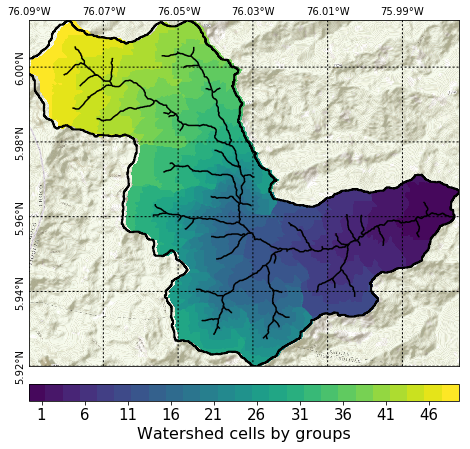

(<mpl_toolkits.basemap.Basemap at 0x7f40a27e9750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f40a2c4f210>)

In [475]:
cuSalgar.Plot_basin(Grup, backMap=True, colorTable=pl.get_cmap('viridis',50),
    colorbarLabel='Watershed cells by groups',
    ruta = '/home/nicolas/Dropbox/Articulos_Prep/Salgar/Grupos_de_celdas.png',
    rutaShp = '/media/nicolas/Home/nicolas/03_SALGAR/vector/red12m',
    shpColor = 'k', per_color = 'k', shpWidth = 1.5,
    cbar_ticks = np.arange(1,50,5)+0.5,
    cbar_ticklabels = np.arange(1,50,5),
    cbar_ticksize = 15)

In [422]:
ruta_retorno = '/media/nicolas/Juesnei/Nicolas/03_Salgar/bin_sto/Salgar_retorno.bin'


v,r = wmf.models.read_float_basin_ncol(ruta_retorno, 75, cuSalgar.ncells, 1)

In [623]:
Max_t0 = []
Max_t2 = []
for i in range(50):
    Max_t0.append(wmf.models.max_capilar[0][Grup == i].mean())
    Max_t2.append(wmf.models.max_gravita[0][Grup == i].mean())
Max_t0 = np.array(Max_t0)
Max_t2 = np.array(Max_t2)

In [625]:
Mat_t0 = []
Mat_t2 = []
Mat_r = []
for j in range(1,300):
    v1,r = wmf.models.read_float_basin_ncol(ruta_store+'.StObin', j, cuSalgar.ncells, 5)
    v2,r = wmf.models.read_float_basin_ncol(ruta_retorno, j, cuSalgar.ncells, 1)
    Var1 = []
    Var2 = []
    Ret = []
    for i in range(50):
        Var1.append(v1[0][Grup == i].mean())
        Var2.append(v1[2][Grup == i].mean())
        Ret.append(v2[0][Grup == i].mean())
    Mat_t0.append(Var1)
    Mat_t2.append(Var2)
    Mat_r.append(Ret)
Mat_t0 = np.array(Mat_t0)
Mat_t2 = np.array(Mat_t2)
Mat_r = np.array(Mat_r)

In [626]:
a = Mat_t0 / Max_t0


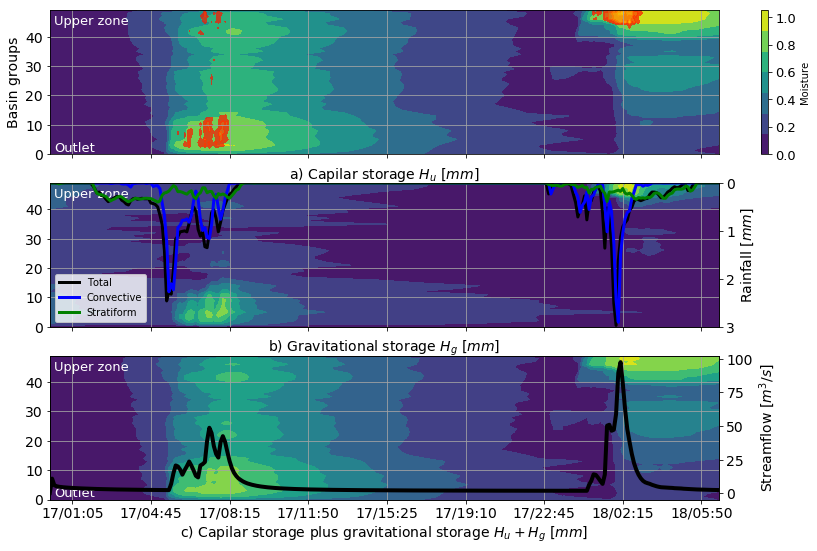

In [631]:
fig = pl.figure(figsize=(15,9))

ax = fig.add_subplot(311)
a = Mat_t0 / Max_t0
m = pl.contourf(a.T, interpolation='None')

cb = pl.colorbar(m, label = 'Moisture')
cb.ax.tick_params(labelsize = 13)
cb.set_ticks(np.arange(0,1.2,0.2))

x = np.arange(Mat_r.shape[0])
y = np.arange(Mat_r.shape[1])
X,Y = np.meshgrid(x,y)
pl.contourf(X,Y,Mat_r.T,np.arange(0.1,0.9,0.1), alpha = 0.7, cmap = pl.get_cmap('autumn'))


ax.set_xticklabels([])
ax.tick_params(labelsize = 14)
a = ax.set_xticks(np.arange(10, 301, 35))
ax.grid(color = '#A4A4A4')
ax.set_xlabel('a) Capilar storage $H_u$ [$mm$]', size = 14)
ax.set_ylabel('Basin groups', size =14)
ax.text(2,1, 'Outlet', size = 13, color = 'w')
ax.text(2,44, 'Upper zone', size = 13, color = 'w')


ax = fig.add_subplot(312)
a = Mat_t2 / Max_t2
m = pl.contourf(a.T, interpolation='None')
cb = pl.colorbar(m)
cb.remove()
ax.set_xticklabels([])
ax.tick_params(labelsize = 14)
a = ax.set_xticks(np.arange(10, 301, 35))
ax.grid(color = '#A4A4A4')
ax.set_xlabel('b) Gravitational storage $H_g$ [$mm$]', size = 14)
ax2 = ax.twinx()
yex = ax2.get_ylim()
ax2.set_ylim(yex[::-1])
ax2.plot(Rain.values, 'k', lw = 3, label = 'Total')
ax2.plot(ConvS[Rain.index].values, 'b', lw = 3, label = 'Convective')
ax2.plot(StraS[Rain.index].values, 'g', lw = 3, label = 'Stratiform')
ax2.set_xlim(0,298)
ax2.set_ylim(3.0,0)
ax2.legend(loc = 0)
ax2.tick_params(labelsize = 14)
ax2.set_ylabel('Rainfall [$mm$]', size = 14, color = 'k')
#ax.text(2,1, 'Outlet', size = 13, color = 'w')
ax.text(2,44, 'Upper zone', size = 13, color = 'w')


ax = fig.add_subplot(313)
a = (Mat_t0 +Mat_t2)/ (Max_t0 + Max_t2)
m = pl.contourf(a.T, interpolation='None')
cb = pl.colorbar(m)
cb.remove()
ax.tick_params(labelsize = 14)
ax.grid(color = '#A4A4A4')
ax.set_xlim(0,300)
a = ax.set_xticks(np.arange(10, 301, 35))
a = ax.set_xticklabels([Texto[i] for i in range(10,300,35)])
ax.set_xlabel('c) Capilar storage plus gravitational storage $H_u+H_g$ [$mm$]', size = 14)
ax2 = ax.twinx()
ax2.plot(Qsim[0], 'k', lw = 4)
ax2.set_xlim(0,298)
ax2.tick_params(labelsize = 14)
ax2.set_ylabel('Streamflow [$m^3/s$]', size = 14)
ax.text(2,1, 'Outlet', size = 13, color = 'w')
ax.text(2,44, 'Upper zone', size = 13, color = 'w')

pl.savefig('/home/nicolas/Dropbox/Articulos_Prep/Salgar/Analisis_humedad_1.png', bbox_inches = 'tight')

In [646]:
Ret = wmf.models.retorned[0]
pos = np.random.choice(10000, cuSalgar.ncells)
RetClass = np.zeros(cuSalgar.ncells)
for c,i in enumerate([5, 10, 20, 50, 70, 100]):
    RetClass[Ret>i] = c+1

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-76.0948989531,5.92463182009,-75.9796567775,6.01716450808&bboxSR=4326&imageSR=4326&size=1500,1204&dpi=96&format=png32&f=image


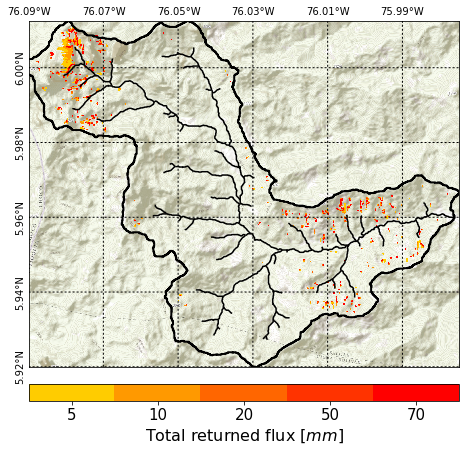

(<mpl_toolkits.basemap.Basemap at 0x7f40b240f690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f40a3dcf850>)

In [648]:
cuSalgar.Plot_basin(RetClass,ZeroAsNaN='si', backMap=True, colorTable=pl.get_cmap('autumn_r',6),
    colorbarLabel='Total returned flux [$mm$]',
    ruta = '/home/nicolas/Dropbox/Articulos_Prep/Salgar/Flujo_retorno.png',
    rutaShp = '/media/nicolas/Home/nicolas/03_SALGAR/vector/red12m',
    shpColor = 'k', per_color = 'k', shpWidth = 1.5,
    cbar_ticks = np.arange(0,6)+0.5,
    cbar_ticklabels = [5, 10, 20, 50, 70, 100],
    cbar_ticksize = 15)

## Lluvia Convectiva y Estratiforme 

In [523]:
Rs = wmf.read_rain_struct('/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Ensayo_12m.hdr')

In [525]:
Val = Rs[' Record'].values

In [571]:
VsumC = np.zeros(cuSalgar.ncells)
VsumS = np.zeros(cuSalgar.ncells)
ConvS = []
StraS = []
rutaConv = '/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Ensayo_12m_conv.bin'
rutaStra = '/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Ensayo_12m_stra.bin'
rutaRain = '/media/nicolas/Home/nicolas/03_SALGAR/bin_rain/Ensayo_12m.bin'
for i in Val:
    if i>1:
        v1,r = wmf.models.read_int_basin(rutaConv, i,cuSalgar.ncells)
        v2,r = wmf.models.read_int_basin(rutaStra, i,cuSalgar.ncells)
        v3,r = wmf.models.read_int_basin(rutaRain, i,cuSalgar.ncells)
        C = (v1/1000.0) * (v3/1000.0)
        S = (v2/1000.0) * (v3/1000.0)
    else:
        C = 0
        S = 0
    VsumC+=C
    VsumS+=S
    ConvS.append(np.mean(C))
    StraS.append(np.mean(S))

In [575]:
ConvS = pd.Series(ConvS, index=Rs.index)
StraS = pd.Series(StraS, index=Rs.index)

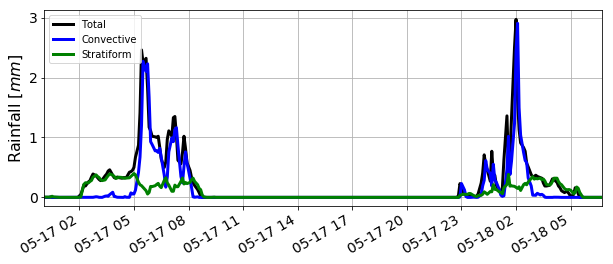

In [632]:
fig = pl.figure(figsize=(10,4))
ax = fig.add_subplot(111)
Rain.plot(linewidth = 3, color = 'k', label = 'Total')
ConvS[Rain.index].plot(linewidth = 3, color = 'b', label = 'Convective')
StraS[Rain.index].plot(linewidth = 3, color = 'g', label = 'Stratiform')
ax.tick_params(labelsize = 14)
ax.set_xlabel('')
ax.set_ylabel('Rainfall [$mm$]', size = 16)
ax.grid()
ax.legend(loc = 0)
pl.savefig('/home/nicolas/Dropbox/Articulos_Prep/Salgar/Convective_Stratiform.png', bbox_inches = 'tight')

http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/export?bbox=-76.0948989531,5.92463182009,-75.9796567775,6.01716450808&bboxSR=4326&imageSR=4326&size=1500,1204&dpi=96&format=png32&f=image


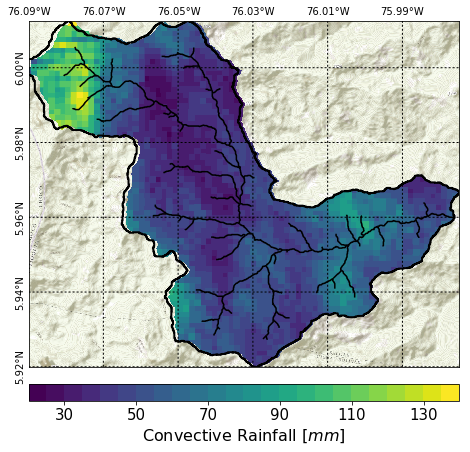

(<mpl_toolkits.basemap.Basemap at 0x7f40f550add0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f40f561bf10>)

In [606]:
cuSalgar.Plot_basin(VsumC, ZeroAsNaN='si', backMap=True,
    ruta = '/home/nicolas/Dropbox/Articulos_Prep/Salgar/Campo_LluviaConvectiva.png',
    per_color = 'k', rutaShp = '/media/nicolas/Home/nicolas/03_SALGAR/vector/red12m', shpColor = 'k',
    shpWidth = 1.5,
    cbar_ticks = np.arange(30,140,20),
    cbar_ticklabels = np.arange(30,140,20),
    cbar_ticksize = 15,
    colorbarLabel = 'Convective Rainfall [$mm$]')

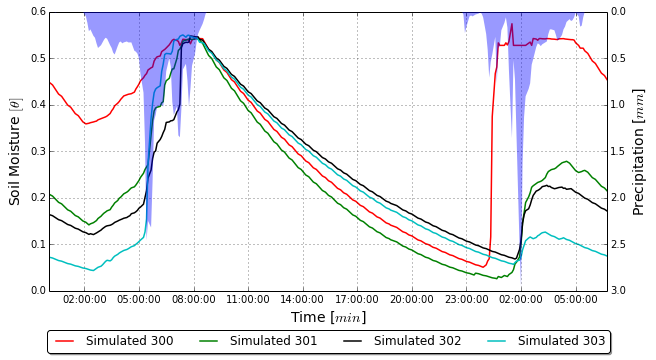

In [30]:
#Serie de humedad simulada
pos = np.where(wmf.models.control_h<>0)[1]
HumedadRel=[]
for i,j,p in zip(Res['Humedad'],[300,301,302,303],pos):
    HumedadRel.append(i/(Hu[p]+Hg[p]))
HumedadRel=np.array(HumedadRel)
wmf.plot_sim_single(HumedadRel,mrain=S.values,Dates=S.index.to_pydatetime(),
    ylabel='Soil Moisture $[\\theta]$',ids=[300,301,302,303],figsize=(10,5),)
    #ruta = 'imagenes12/HumedadSimulada_18.png')

### Sensibilidad en el mediano plazo variando las condiciones desde 24 horas antes del evento 

In [31]:
cuSalgar.set_Storage(Hu*0.8,0)
QsimOrig = Res['Qsim'][0]

In [32]:
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)
S = wmf.read_mean_rain('lluvia/Mayo_18_19_12mts.hdr',Npasos,Inicio)
QsimEdit = Res['Qsim'][0]50.0

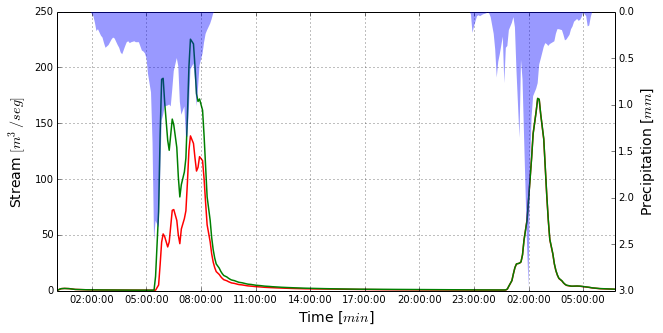

In [33]:
QsimJoin = np.vstack([QsimOrig,QsimEdit])
wmf.plot_sim_single(QsimJoin,legend=False,Dates=S.index.to_pydatetime(),figsize=(10,5),
    ruta = 'imagenes12/Qsim_comparado_Hu',mrain=S.values)

### Análisis de la variabilidad de la humedad en la cuenca 

Se observa como varía la humedad en la cuenca en diferentes puntos de control, 
en el punto de contol 2000 (ubicado en la zona alta de la cuenca) se observa como 
durante el evento del 18 de Mayo se da una saturación importante 1 hora antes del evento, 
el suelo se encontraba con un valor de humedad de alrededor del 55%, este valor se 
mantiene, y cuando sucede el aguacero de las 2:00 se hace más crudo.

In [75]:
#Actualizar estados
for pos,i in enumerate(Res['Storage']):
    cuSalgar.set_Storage(i,pos)
cuSalgar.set_Storage(0,0)
Npasos = 225
Inicio = 1
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)
S = wmf.read_mean_rain('lluvia/Mayo_18_19_12mts.hdr',Npasos,Inicio)

#### Humedad Simulada Antes del evento 
A continuación se presenta la humedad simulada desde el 17 de mayo, y justo antes de que comience el evento del 18 de mayo.

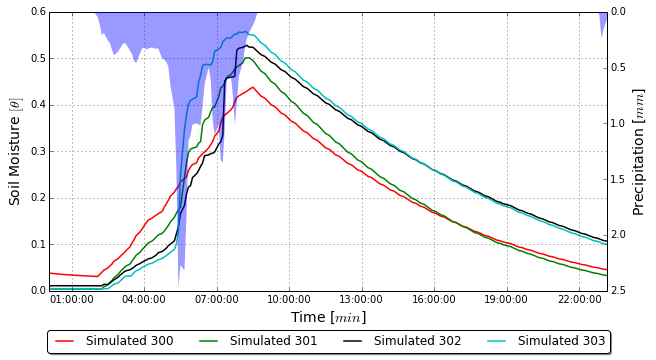

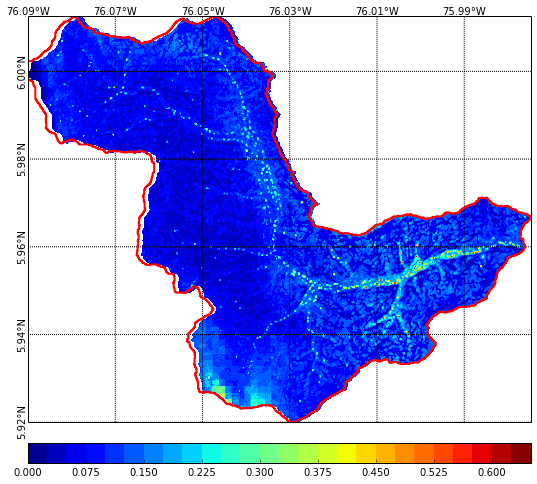

In [77]:
#Series de humedad en puntos de control
pos = np.where(wmf.models.control_h<>0)[1]
HumedadRel=[]
for i,j,p in zip(Res['Humedad'],[300,301,302,303],pos):
    HumedadRel.append(i/(Hu[p]+Hg[p]))
HumedadRel=np.array(HumedadRel)
wmf.plot_sim_single(HumedadRel,mrain=S.values,Dates=S.index.to_pydatetime(),
    ylabel='Soil Moisture $[\\theta]$',ids=[300,301,302,303],figsize=(10,5),
    ruta = 'imagenes12/HumedadSimulada_Antes18.png')
#Mapa de humedad antes del evento 
Humedad = (Res['Storage'][2]+Res['Storage'][0])/(Hu+Hg)
cuSalgar.Plot_basin(vec=Humedad,ZeroAsNaN='si',ruta='imagenes12/Mapa_Humedad_Antes18.png')

#### Humedad simulada durante entre las 10:55 y 1:00 AM antes del evento del 18

Esta es la humedad presentada por el modelo durante el evento 

In [82]:
#Actualizar estados
#for pos,i in enumerate(Res['Storage']):
#    cuSalgar.set_Storage(i,pos)
Npasos = 20
Inicio = 225
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)
S = wmf.read_mean_rain('lluvia/Mayo_18_19_12mts.hdr',Npasos,Inicio)

In [ ]:
#Serie de humedad
pos = np.where(wmf.models.control_h<>0)[1]
HumedadRel=[]
for i,j,p in zip(Res['Humedad'],[300,301,302,303],pos):
    HumedadRel.append(i/(Hu[p]+Hg[p]))
HumedadRel=np.array(HumedadRel)
wmf.plot_sim_single(HumedadRel,mrain=S.values,Dates=S.index.to_pydatetime(),
    ylabel='Soil Moisture $[\\theta]$',ids=[300,301,302,303],figsize=(10,5),
    ruta = 'imagenes12/HumedadSimulada_18_1:00AM.png')

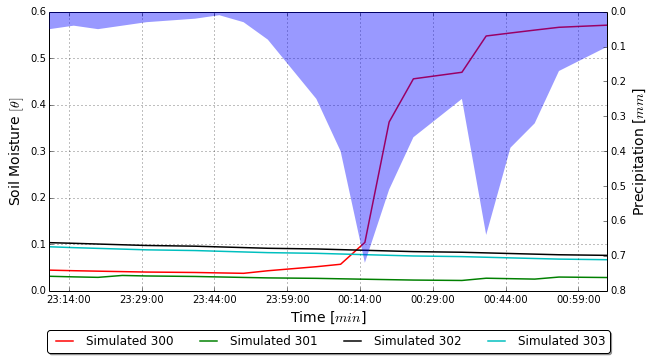

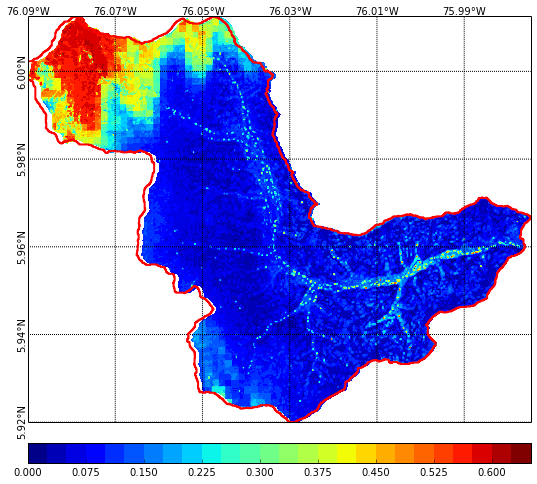

In [85]:
#Mapa de humedad antes del evento 
Humedad = (Res['Storage'][2]+Res['Storage'][0])/(Hu+Hg)
cuSalgar.Plot_basin(vec=Humedad,ZeroAsNaN='si',ruta='imagenes12/Mapa_Humedad_18_1:00AM.png')

#### Humedad simulada durante el evento en 3 pts de control 

Esta es la humedad presentada por el modelo durante el evento 

In [86]:
#Actualizar estados
#for pos,i in enumerate(Res['Storage']):
#    cuSalgar.set_Storage(i,pos)
Npasos = 70
Inicio = 225
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)
S = wmf.read_mean_rain('lluvia/Mayo_18_19_12mts.hdr',Npasos,Inicio)

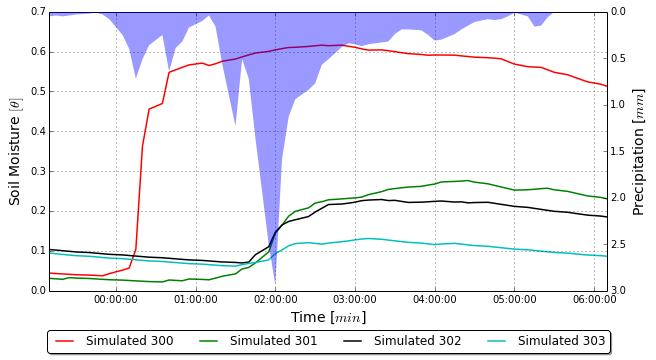

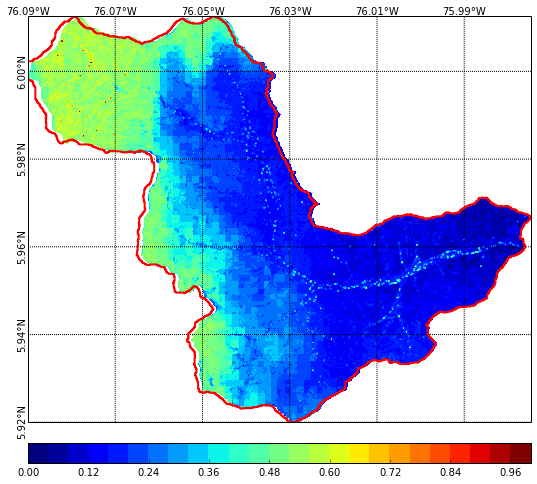

In [87]:
#Serie de humedad
pos = np.where(wmf.models.control_h<>0)[1]
HumedadRel=[]
for i,j,p in zip(Res['Humedad'],[300,301,302,303],pos):
    HumedadRel.append(i/(Hu[p]+Hg[p]))
HumedadRel=np.array(HumedadRel)
wmf.plot_sim_single(HumedadRel,mrain=S.values,Dates=S.index.to_pydatetime(),
    ylabel='Soil Moisture $[\\theta]$',ids=[300,301,302,303],figsize=(10,5),
    ruta = 'imagenes12/HumedadSimulada_18_Durante.png')
#Mapa de humedad antes del evento 
Humedad = (Res['Storage'][2]+Res['Storage'][0])/(Hu+Hg)
cuSalgar.Plot_basin(vec=Humedad,ZeroAsNaN='si',ruta='imagenes12/Mapa_Humedad_18_Durante.png')

### Múltiples puntos de control en la zona alta

A continuación se establecen 200 ptos de control en la zona alta de la cuenca, donde ocurrio el evento importante de agua, estos puntos de control se localizarán de forma aleatorioa dentro de la región establecida.

In [58]:
#Reinicia puntos de control y establece puntos aleatorios
wmf.models.control_h = np.zeros((1,cuSalgar.ncells))
xy = np.random.uniform(-76.10,-76.078,2000)
xy = np.vstack([xy,np.random.uniform(5.98,6.14,2000)])
#Obtiene las coordeandas al interior de la cuenca 
IdsHumedad = cuSalgar.set_Control(xy,np.arange(100,2100),tipo='H')
x,y = wmf.cu.basin_coordxy(cuSalgar.structure,cuSalgar.ncells)
pos = np.where(wmf.models.control_h<>0)[1]
Coord = np.vstack([x[pos],y[pos]])
#Guarda el vector de los puntos de control
wmf.Save_Points2Map(Coord,IdsHumedad[0].astype(int),'vector/ptos_controlH_random12.shp')

In [89]:
#wmf.models.storage = Res['Storage']
#cuSalgar.set_Storage(10,3)
Npasos = 80
Inicio = 225
ruta_lluvia = 'lluvia/Mayo_18_19_12mts.bin'
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)
S = wmf.read_mean_rain('lluvia/Mayo_18_19_12mts.hdr',Npasos,Inicio)

In [59]:
pos = np.where(wmf.models.control_h<>0)[1]
HumedadRel=[]
for i,p in zip(Res['Humedad'],pos):
    HumedadRel.append(i/(Hu[p]+Hg[p]))
HumedadRel=np.array(HumedadRel)
HumPer={}
for i in [90,75,50,25,10]:
    HumPer.update({str(i):np.percentile(HumedadRel,i,axis=0)})

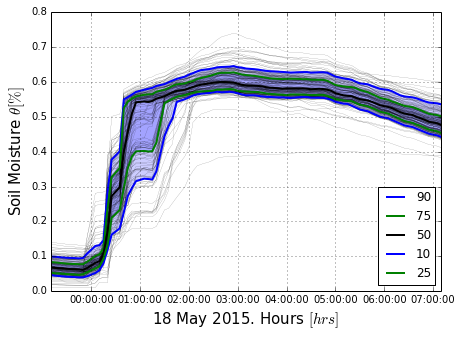

In [91]:
colors = ['b','g','k','b','g']
fig = pl.figure(edgecolor='w',facecolor='w',figsize=(7,5))
ax = fig.add_subplot(111)
for i in HumedadRel:
    ax.plot(S.index.to_pydatetime(),i,'k',lw=0.1)
for i,c in zip(HumPer.keys(),colors):
    ax.plot(S.index.to_pydatetime(),HumPer[i],c=c,lw=2,label=i)
ax.fill_between(S.index.to_pydatetime(),HumPer['10'],HumPer['90'],alpha=0.2)
ax.fill_between(S.index.to_pydatetime(),HumPer['25'],HumPer['75'],alpha=0.2)

ax.grid(True)
ax.legend(loc=0)
ax.set_xlabel('18 May 2015. Hours $[hrs]$',size=15)
ax.set_ylabel('Soil Moisture $\\theta [\\%]$',size=15)
pl.savefig('imagenes12/Soil_Moisture_Percentiles_18_10:55_1:50.png')

### Comparación del punto de ocurrencia de la humedad Vs Geomorfología

Se toma el punto de maximo incremento en la humedad y se compara con las características geomorfológicas de la cuenca en el lugar donde ocurren.

Características:
- Pendiente.
- HAND.
- Localización Lat,Long

In [92]:
# Características de la humedad
HumDiffVal = map(np.diff,HumedadRel)
HumDesend = np.array([i[40:].mean() for i in HumDiffVal])
HumMax = np.max(HumedadRel,axis=1)
# Caracteristicas geomorfo en esos puntos 
Pend = cuSalgar.CellSlope[pos]

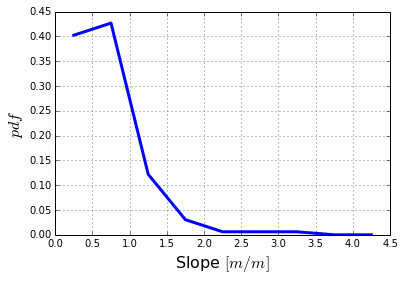

In [93]:
fig = pl.figure()
ax = fig.add_subplot(111)
h,b = np.histogram(Pend,bins=np.arange(0,5,0.5))
h = h.astype(float); h = h/h.sum()
b = (b[:-1]+b[1:])/2.0
ax.plot(b,h,lw=3)
ax.grid(True)
ax.set_xlabel('Slope $[m/m]$',size = 16)
ax.set_ylabel('$pdf$',size=16)
pl.savefig('imagenes12/Geomorpho_pend_hist_montecarloZone.png',bbox_inches='tight')

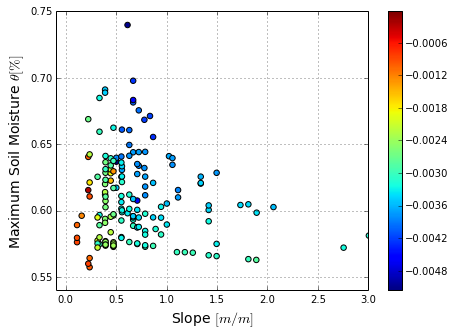

In [96]:
fig = pl.figure(edgecolor='w',facecolor='w',figsize=(7,5))
ax = fig.add_subplot(111)
sca = ax.scatter(Pend,HumMax,c = HumDesend,s=30)
ax.set_xlim(-0.1,3)
ax.set_ylim(0.54,0.75)
ax.set_xlabel('Slope $[m/m]$',size=14)
ax.set_ylabel('Maximum Soil Moisture $\\theta [\\%]$',size=14)
ax.grid(True)
fig.colorbar(sca)
pl.savefig('imagenes12/Soil_Moisture_Max_18_10:55_1:50.png',bbox_inches='tight')

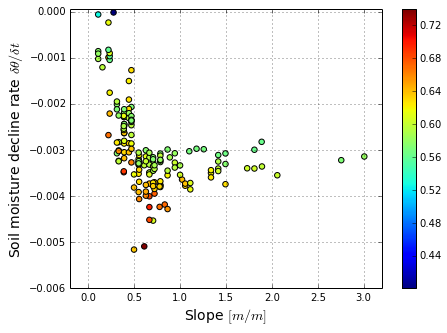

In [98]:
fig = pl.figure(edgecolor='w',facecolor='w',figsize=(7,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(Pend,HumDesend,c = HumMax,s=30)
fig.colorbar(scatter)
ax.set_xlim(-0.2,3.2)
ax.set_ylim(-0.006,0.00005)
ax.set_xlabel('Slope $[m/m]$',size=14)
ax.set_ylabel('Soil moisture decline rate $\\delta \\theta / \\delta t$',size=14)
ax.grid(True)
pl.savefig('imagenes12/Soil_Moisture_descend_rate_18_10:55_1:50.png',bbox_inches='tight')

### Variación condiciones iniciales antes de la tormenta

1. Encuentra la zona donde ocurre la mayor parte del evento previo, entre las 10:55 y la 1:15 AM del 18 de mayo.
2. Según el análisis anterior y de acuerdo a donde posteriormente ocurre el evento, esta zona es la más voluble a cambios en los estados iniciales de humedad, o a las condiciones antecedentes de lluvia.
3. Variaciones de estados antecedentes:

In [ ]:
#Encuentra la zona donde ocurre la mayor parte del evento previo 
Vsum = np.zeros(cuSalgar.ncells)
for i in range(79,105):
    v,r = wmf.models.read_int_basin('lluvia/Mayo_18_19_12mts.bin',i,cuSalgar.ncells)
    Vsum +=v/1000.0

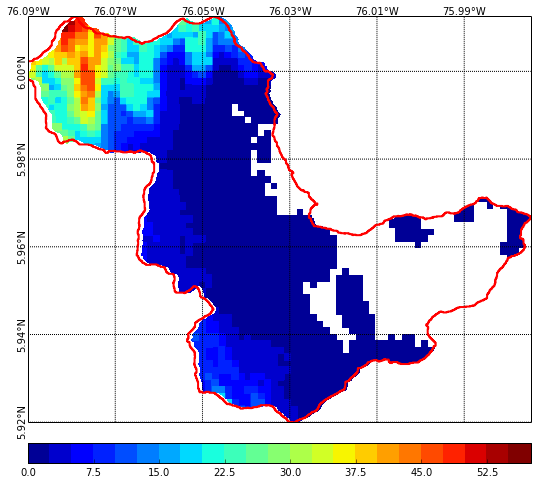

In [101]:
cuSalgar.Plot_basin(Vsum,ZeroAsNaN='si',ruta='imagenes12/Rain_18_10:55_1:15.png')

In [92]:
(5+5+5+4)/4.0

4.75

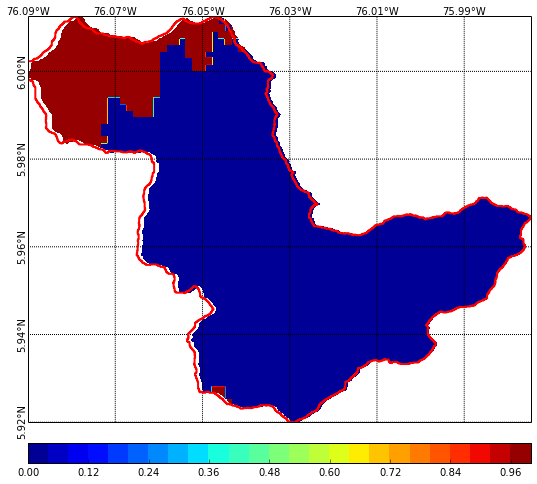

In [102]:
#Mapa mascara para realizar las variaciones
MapMask = np.zeros(cuSalgar.ncells)
MapMask[Vsum>14]=1
cuSalgar.Plot_basin(MapMask)

In [103]:
#Ejecucion hasta el punto antes del evento
for i in range(4):
    cuSalgar.set_Storage(i,0)
cuSalgar.set_Storage(10,3)
Npasos = 245
Inicio = 1
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)
S = wmf.read_mean_rain('lluvia/Mayo_18_19_12mts.hdr',Npasos,Inicio)

In [104]:
#Actualiza estados reales 
for pos,i in enumerate(Res['Storage']):
    cuSalgar.set_Storage(i,pos)
StorageReal = np.copy(Res['Storage'])

In [105]:
#Ejecuta continuacion guarda el caudal 
Npasos = 40
Inicio = 246
Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)#ruta_storage='storage_17_18.bin')
Qvar=[Res['Qsim'][0]]

In [106]:
# Figura de estados alterados (no es el grupo de rock de medellin)
Npasos = 40
Inicio = 246
for i in [-0.5,-0.3,0.3,0.6]:
    #Altera el estado de simulacion anteiror 
    HuNuevo = StorageReal[0]+MapMask*Hu*i
    cuSalgar.set_Storage(HuNuevo,0)
    Res = cuSalgar.run_shia(Calibracion,ruta_lluvia,Npasos,Inicio)#ruta_storage='storage_17_18.bin')
    S = wmf.read_mean_rain('lluvia/Mayo_18_19_12mts.hdr',Npasos,Inicio)
    Qvar.append(Res['Qsim'][0])
Qvar = np.array(Qvar)

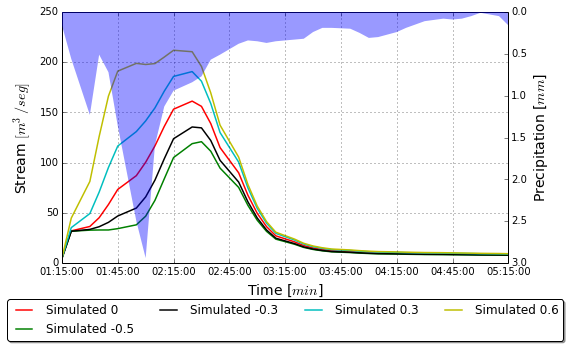

In [107]:
wmf.plot_sim_single(Qvar,mrain=S.values,Dates=S.index.to_pydatetime(),
    ids = [0, -0.5,-0.3,0.3,0.6],
    ruta = 'imagenes12/Qsim_Initial_oscillation_18_01:00_04:00.png')